In [167]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

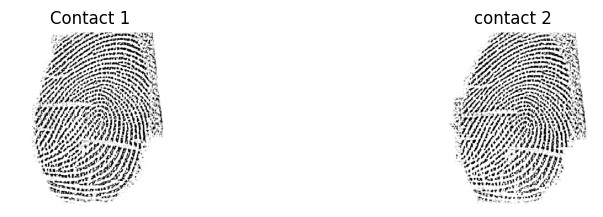

In [168]:
contact_image_raw_1 = cv2.imread('../PolyU/contact-based_fingerprints/first_session/1_1.jpg')
contact_image_gray_1 = cv2.cvtColor(contact_image_raw_1, cv2.COLOR_BGR2GRAY)

contact_image_raw_2 = cv2.imread('../PolyU/contact-based_fingerprints/first_session/1_2.jpg')
contact_image_gray_2 = cv2.cvtColor(contact_image_raw_2, cv2.COLOR_BGR2GRAY)
# contact_image_gray_2 = cv2.flip(contact_image_gray_2, 0)
# contact_image_gray_2 = cv2.rotate(contact_image_gray_2, cv2.ROTATE_90_COUNTERCLOCKWISE)


plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(contact_image_gray_1, cmap='gray')
plt.title('Contact 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(contact_image_gray_2, cmap='gray')
plt.title('contact 2')
plt.axis('off')
plt.show()

In [169]:
def align_fingerprints(img1, img2, verbose = False, MIN_MATCH_COUNT = 8):
    # Step 1: Convert images to grayscale
    # gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    # gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Detect ORB key points and descriptors
    orb = cv2.ORB_create()
    print('in align func',np.shape(img1), np.shape(img2))
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    # Step 3: Match key points using FLANN matcher
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=2)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1, des2, k=2)
    # Filter matches using Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    print('Good matches',len(good_matches))
    if verbose:
        matched_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        # Display matched keypoints
        plt.figure(figsize=(15, 10))
        plt.title('Matched Keypoints')
        plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    # matchesMask = [[0,0] for i in range(len(matches))]
 
    # # ratio test.
    # for i,(m,n) in enumerate(matches):
    #     if( m.distance < 0.1*n.distance):
    #         matchesMask[i]=[1,0]
    # draw_params = dict(matchColor = (0,255,0),
    #                    singlePointColor = (255,0,0),
    #                    matchesMask = matchesMask,flags = 0)
     
    # # drawing nearest neighbours
    # img = cv.drawMatchesKnn(main_image,
    #                         key_point1,
    #                         sub_image,
    #                         key_point2,
    #                         matches,
    #                         None,
    #                         **draw_params)
    # return img
    
    # Check if enough matches are found
    if len(good_matches) > MIN_MATCH_COUNT:
        # Extract locations of good matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Step 4: Compute homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Step 5: Warp one image to align with the other
        h, w = img1.shape[:2]
        aligned_img = cv2.warpPerspective(img1, M, (w, h))
        if verbose:
            print(M,w, h)
            # print(f'good matches:{len(good_matches)}')
            # Display the aligned image and the original for comparison
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title('Original Image')
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            
            plt.subplot(1, 2, 2)
            plt.title('Aligned Image')
            plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
            
            plt.show()
            print('Matched')
            return aligned_img
        else:
            return True, good_matches
    else:
        if verbose:
            print("Not Matched")
            return None
        else:
            return False, good_matches

in align func (356, 328) (356, 328)
Good matches 13


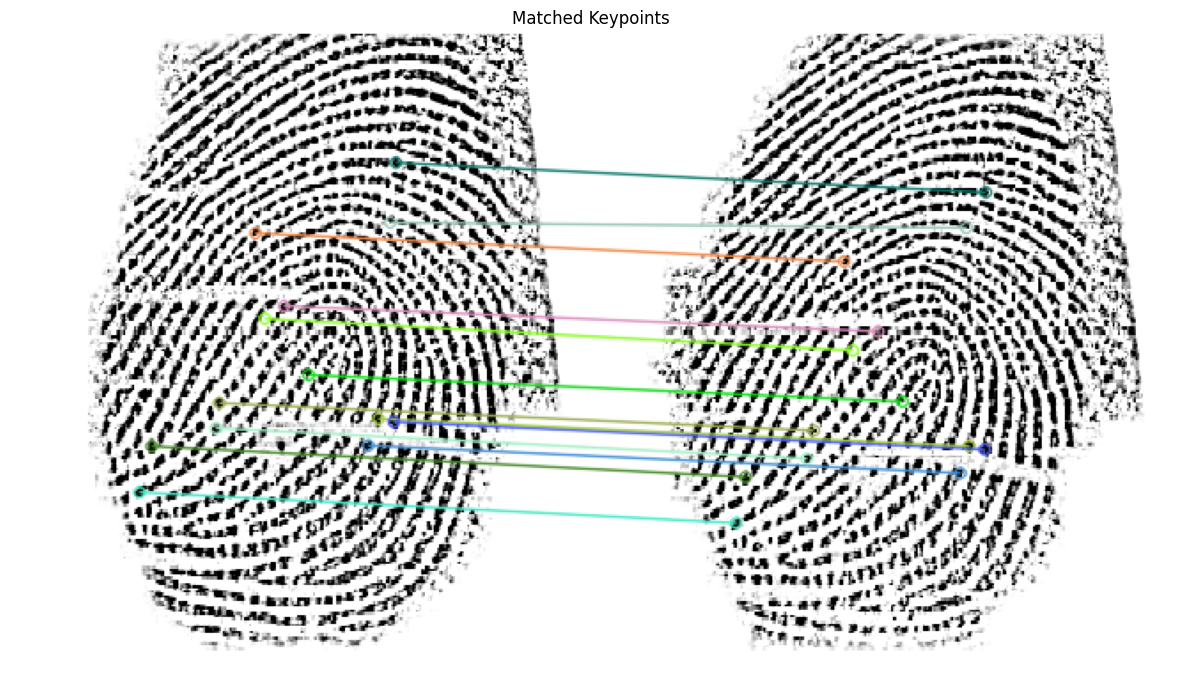

[[ 1.00952596e+00  3.07636626e-02  1.17340035e+00]
 [-1.49267453e-02  1.03929887e+00  1.45157923e+01]
 [ 2.80318529e-07  9.02753505e-05  1.00000000e+00]] 328 356


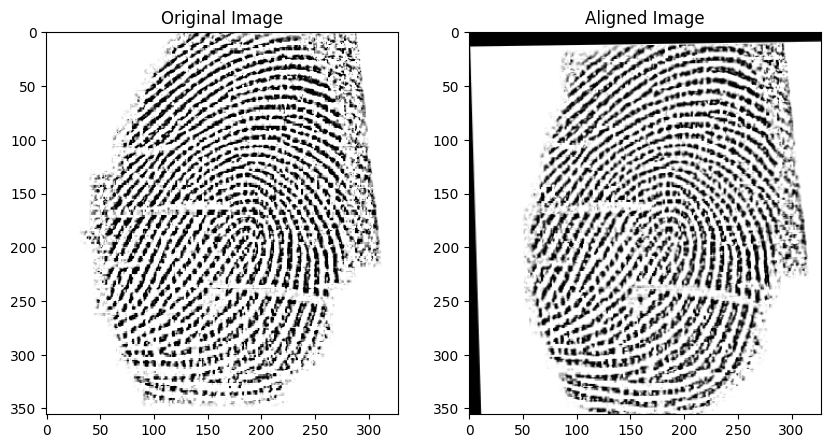

Matched


In [170]:
matching = align_fingerprints(contact_image_gray_1, contact_image_gray_2, verbose=True)

In [171]:
def pre_process_contactless(person, id):
    contactless_image_raw = cv2.imread(f'../PolyU/processed_contactless_2d_fingerprint_images/first_session/p{person}/p{id}.bmp')
    contactless_image_gray = cv2.cvtColor(contactless_image_raw, cv2.COLOR_BGR2GRAY)

    # Histogram Equi
    equilized_image = cv2.equalizeHist(contactless_image_gray)
    # AMT
    AMT_image = cv2.adaptiveThreshold(equilized_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

    #gabor
    ksize = 21  # Size of the Gabor kernel
    sigma = 5.0  # Standard deviation of the Gaussian envelope
    theta = 0  # Orientation of the normal to the parallel stripes
    lambd = 10.0  # Wavelength of the sinusoidal factor
    gamma = 0.5  # Spatial aspect ratio
    phi = 0  # Phase offset
    
    # Generate Gabor kernel
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
    gabor_filtered_1 = cv2.filter2D(AMT_image, cv2.CV_8UC3, gabor_kernel)
    return AMT_image

(-0.5, 349.5, 224.5, -0.5)

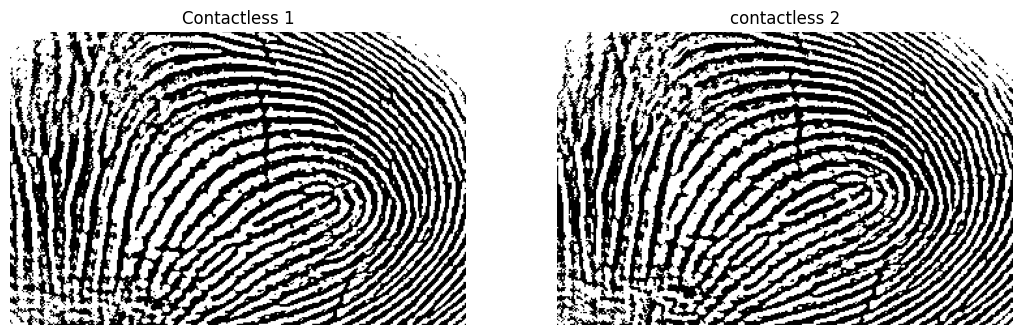

In [172]:
# Pre-Processing for contactless 1
AMT_image_1 = pre_process_contactless(person = 1, id = 1)
AMT_image_2 = pre_process_contactless(person = 1, id = 2)

plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.imshow(AMT_image_1, cmap='gray')
plt.title('Contactless 1')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(AMT_image_2, cmap='gray')
plt.title('contactless 2')
plt.axis('off')

in align func (225, 350) (225, 350)
Good matches 42


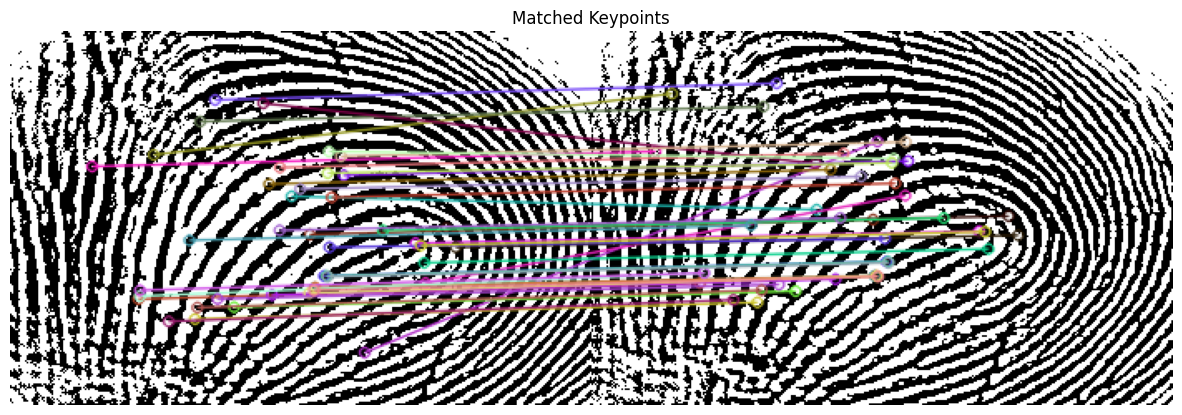

[[ 1.00450239e+00  2.17826486e-02 -1.30010678e+01]
 [ 9.00475053e-03  1.01795733e+00 -1.08552965e+01]
 [-5.74952054e-05  1.74711084e-04  1.00000000e+00]] 350 225


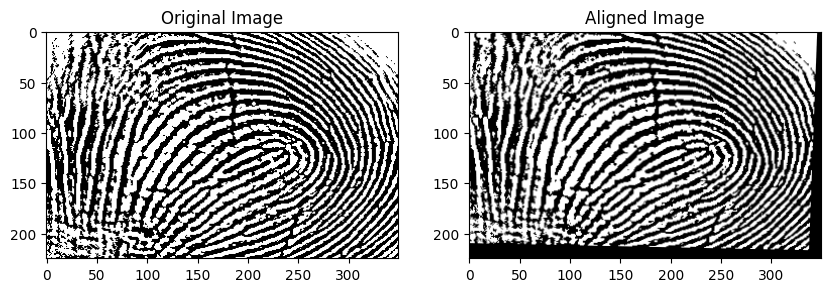

Matched


In [173]:
aligned_image = align_fingerprints(AMT_image_1, AMT_image_2, verbose=True)

In [174]:
print(np.arange(6,6))

[]


In [175]:
total_persons = 5

fails = 0

for i in np.arange(1,total_persons +1):
    for id1 in np.arange(1,7):
        for id2 in np.arange(id1+1, 7):
            img1 = pre_process_contactless(person = i, id = id1)
            img2 = pre_process_contactless(person = i, id = id2)
            match, good_matches = align_fingerprints(img1, img2)
            # print(len(good_matches))
            if not match:
                fails += 1
                # match, good_matches = align_fingerprints(img1, img2, verbose=False)

                print('failed', f'person:{i} id :{id1} {id2} matches:{len(good_matches)}')

total_tries = total_persons * 15
print('percentage_of_fails', fails / total_tries)  

in align func (225, 350) (225, 350)
Good matches 42
in align func (225, 350) (225, 350)
Good matches 33
in align func (225, 350) (225, 350)
Good matches 42
in align func (225, 350) (225, 350)
Good matches 30
in align func (225, 350) (225, 350)
Good matches 70
in align func (225, 350) (225, 350)
Good matches 49
in align func (225, 350) (225, 350)
Good matches 42
in align func (225, 350) (225, 350)
Good matches 35
in align func (225, 350) (225, 350)
Good matches 38
in align func (225, 350) (225, 350)
Good matches 68
in align func (225, 350) (225, 350)
Good matches 54
in align func (225, 350) (225, 350)
Good matches 44
in align func (225, 350) (225, 350)
Good matches 36
in align func (225, 350) (225, 350)
Good matches 67
in align func (225, 350) (225, 350)
Good matches 50
in align func (225, 350) (225, 350)
Good matches 35
in align func (225, 350) (225, 350)
Good matches 29
in align func (225, 350) (225, 350)
Good matches 22
in align func (225, 350) (225, 350)
Good matches 19
in align fun

In [176]:
total = 15
false_positive= 0
for person1 in np.arange(1,total):
    for person2 in np.arange(person1+1, total+1):
        for id1 in np.arange(1,7):
            for id2 in np.arange(id1+1, 7):
                img1 = pre_process_contactless(person = person1, id = id1)
                img2 = pre_process_contactless(person = person2, id = id2)
                match, good_matches = align_fingerprints(img1, img2, MIN_MATCH_COUNT=12)
                if match:
                    false_positive += 1
                    print(f'false positive - person{person1} id{id1} person{person2} id{id2}')
print(f'False Positive {100*false_positive / (total*(total - 1)*36 / 2)} %')

in align func (225, 350) (225, 350)
Good matches 5
in align func (225, 350) (225, 350)
Good matches 4
in align func (225, 350) (225, 350)
Good matches 5
in align func (225, 350) (225, 350)
Good matches 10
in align func (225, 350) (225, 350)
Good matches 1
in align func (225, 350) (225, 350)
Good matches 7
in align func (225, 350) (225, 350)
Good matches 4
in align func (225, 350) (225, 350)
Good matches 3
in align func (225, 350) (225, 350)
Good matches 5
in align func (225, 350) (225, 350)
Good matches 7
in align func (225, 350) (225, 350)
Good matches 5
in align func (225, 350) (225, 350)
Good matches 1
in align func (225, 350) (225, 350)
Good matches 4
in align func (225, 350) (225, 350)
Good matches 12
in align func (225, 350) (225, 350)
Good matches 9
in align func (225, 350) (225, 350)
Good matches 5
in align func (225, 350) (225, 350)
Good matches 3
in align func (225, 350) (225, 350)
Good matches 2
in align func (225, 350) (225, 350)
Good matches 4
in align func (225, 350) (225

(225, 350) (225, 350)
WAVELET
(226, 350)
(226, 350)
in align func (226, 350) (226, 350)
Good matches 48


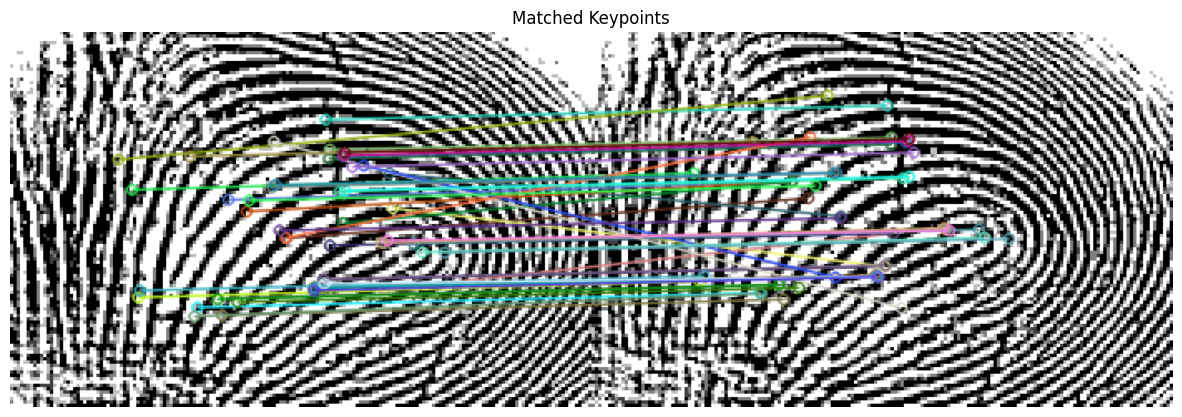

[[ 9.83000919e-01 -4.30695772e-03 -9.96987493e+00]
 [ 2.40093401e-03  9.92844660e-01 -9.15110172e+00]
 [-5.93120591e-05 -1.03551166e-05  1.00000000e+00]] 350 226


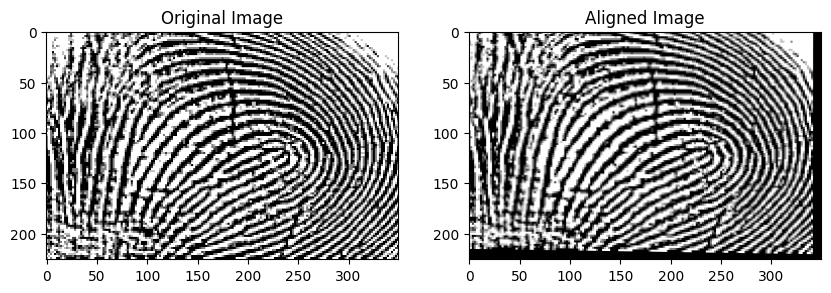

Matched
WITHOUT WAVELET
in align func (225, 350) (225, 350)
Good matches 43


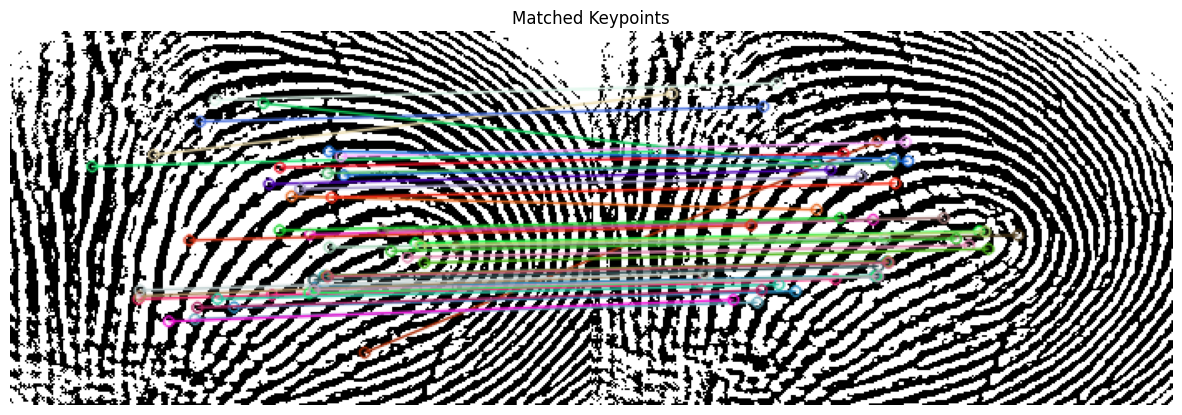

[[ 1.00248572e+00  2.72781944e-02 -1.32826445e+01]
 [ 5.73500311e-03  1.02408091e+00 -1.09521677e+01]
 [-8.25597398e-05  2.11966868e-04  1.00000000e+00]] 350 225


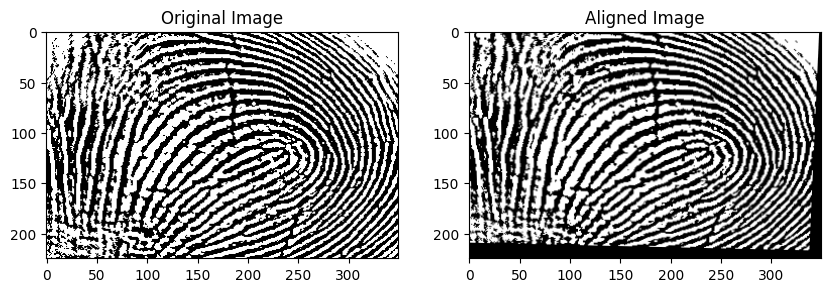

Matched


In [181]:
import pywt
import pywt.data

def apply_wavelet_transform(img, wavelet='haar'):
    # Perform a 2D Discrete Wavelet Transform
    coeffs2 = pywt.dwt2(img, wavelet)
    LL, (LH, HL, HH) = coeffs2
    
    # You can choose to reconstruct the image from specific coefficients
    reconstructed_img = pywt.idwt2((LL, (np.zeros_like(LH), np.zeros_like(HL), np.zeros_like(HH))), wavelet)

    reconstructed_img = np.uint8(reconstructed_img)

    print(np.shape(reconstructed_img))
    return reconstructed_img

def preprocess_and_match(img1, img2, wavelet='haar', verbose=False):
    # Apply wavelet transform to the images
    img1_transformed = apply_wavelet_transform(img1, wavelet)
    img2_transformed = apply_wavelet_transform(img2, wavelet)
    
    # Call your alignment function
    
    return align_fingerprints(img1_transformed, img2_transformed, verbose)

# Example usage
img1 = pre_process_contactless(person = 1, id = 1)
img2 = pre_process_contactless(person = 1, id = 2)
print(np.shape(img1), np.shape(img2))
print("WAVELET")
preprocess_and_match(img1, img2, wavelet='haar', verbose=True)
print("WITHOUT WAVELET")
matching = align_fingerprints(img1, img2, verbose=True)


In [178]:
'janvi'

'janvi'